In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# Configuration Parameters
config = {
    "input_dim": 784,  # Number of input features (e.g., 28x28 images flattened for MNIST)
    "output_dim": 10,  # Number of output classes (e.g., 10 classes for MNIST)
    "trainable_layers": 500,  # Number of trainable layers
    "trainable_units": 128,  # Number of units in each trainable layer
    "fixed_layers": 50,  # Number of fixed random layers
    "fixed_units": 64,  # Number of units in each fixed random layer
    "reverse_layers": False,  # Flag to reverse trainable and fixed random layers
    "batch_size": 6000,  # Entire dataset as batch size for training
    "epochs": 100,  # Number of epochs to train
    "learning_rate": 0.001,  # Learning rate for the optimizer
    "data_subset": 0.1,  # Fraction of the data to use for training (0 < data_subset <= 1.0)
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # Device configuration
    "num_workers": 8  # Number of workers for DataLoader
}

print(f"Using device: {config['device']}")

class FixedRandomLayerWithNorm(nn.Module):
    """Fixed random layer with normalization."""
    def __init__(self, input_dim, output_dim, device):
        super(FixedRandomLayerWithNorm, self).__init__()
        self.weights = torch.empty(input_dim, output_dim, device=device)
        nn.init.kaiming_uniform_(self.weights, nonlinearity='relu')
        self.norm = nn.LayerNorm(output_dim)
    
    def forward(self, x):
        x = x.mm(self.weights)
        return self.norm(x)


class TestNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, 
                 trainable_layers, trainable_units,
                 fixed_layers, fixed_units, reverse_layers, device):
        super(TestNetwork, self).__init__()
        
        self.layers = nn.ModuleList()
        
        # Determine layer order based on reverse_layers flag
        layer_order = []
        if reverse_layers:
            layer_order = ["fixed"] * fixed_layers + ["trainable"] * trainable_layers
        else:
            layer_order = ["trainable"] * trainable_layers + ["fixed"] * fixed_layers

        last_dim = input_dim
        for layer_type in layer_order:
            if layer_type == "trainable":
                # Use the same number of units for each trainable layer
                unit = trainable_units
                self.layers.append(nn.Linear(last_dim, unit))
                self.layers.append(nn.ReLU())
                last_dim = unit
            elif layer_type == "fixed":
                # Use the same number of units for each fixed layer
                unit = fixed_units
                self.layers.append(FixedRandomLayer(last_dim, unit, device))
                last_dim = unit
        
        # Output layer
        self.output = nn.Linear(last_dim, output_dim)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output(x)

# Model Creation Function
def create_model(config):
    """Creates and returns the model based on the configuration."""
    model = TestNetwork(
        input_dim=config["input_dim"], 
        output_dim=config["output_dim"], 
        trainable_layers=config["trainable_layers"], 
        trainable_units=config["trainable_units"],  # Using single value for all layers
        fixed_layers=config["fixed_layers"], 
        fixed_units=config["fixed_units"],  # Using single value for all layers
        reverse_layers=config["reverse_layers"], 
        device=config["device"]
    ).to(config["device"])
    return model

# Data Loading and Pre-loading Function
def load_and_preload_data(config):
    """Loads the MNIST dataset, moves it to the GPU, and returns in-memory datasets."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load the dataset into CPU memory first
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Use a subset of the training data if data_subset < 1.0
    max_length = len(trainset)
    subset_length = int(max_length * config["data_subset"])
    print(f"Maximum length of the dataset: {max_length}")
    print(f"Using {subset_length} samples for training ({config['data_subset']*100:.1f}% of the dataset)")
    if config["data_subset"] < 1.0:
        trainset = torch.utils.data.Subset(trainset, range(subset_length))

    # Move the entire dataset to the GPU
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=config["batch_size"], shuffle=False, num_workers=config["num_workers"])
    testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False, num_workers=config["num_workers"])
    
    # Pre-load entire training and testing dataset into GPU memory
    train_data, train_labels = next(iter(trainloader))
    train_data, train_labels = train_data.view(-1, config["input_dim"]).to(config["device"]), train_labels.to(config["device"])

    test_data, test_labels = next(iter(testloader))
    test_data, test_labels = test_data.view(-1, config["input_dim"]).to(config["device"]), test_labels.to(config["device"])

    return (train_data, train_labels), (test_data, test_labels)

# Training Function
def train_model(model, train_data, train_labels, test_data, test_labels, config):
    """Trains the model using the given dataset and configuration with a single tqdm progress bar."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    total_steps_per_epoch = len(train_data) // config["batch_size"]
    total_steps = total_steps_per_epoch * config["epochs"]

    # Combined tqdm progress bar for all epochs
    with tqdm(total=total_steps, desc="Training", unit='step') as pbar:
        for epoch in range(config["epochs"]):
            running_loss = 0.0

            for i in range(total_steps_per_epoch):
                # Get a batch of data
                batch_start = i * config["batch_size"]
                batch_end = batch_start + config["batch_size"]
                inputs = train_data[batch_start:batch_end]
                labels = train_labels[batch_start:batch_end]


                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Update tqdm bar for each step
                current_step = epoch * total_steps_per_epoch + i + 1
                pbar.set_postfix(epoch=f"{epoch + 1}/{config['epochs']}", step=f"{current_step}/{total_steps}", loss=f"{running_loss / (i + 1):.4f}")
                pbar.update(1)  # Increment progress bar by one step

            # Evaluate on the test set after each epoch
            test_accuracy = evaluate_model(model, test_data, test_labels, config)
            pbar.set_postfix(epoch=f"{epoch + 1}/{config['epochs']}", step=f"{current_step}/{total_steps}", loss=f"{running_loss / total_steps_per_epoch:.4f}", accuracy=f"{test_accuracy:.2f}%")

    print("Finished Training")

# Evaluation Function
def evaluate_model(model, test_data, test_labels, config):
    """Evaluates the model on the test data and returns the accuracy."""
    correct = 0
    total = test_labels.size(0)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(test_data)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == test_labels).sum().item()
    model.train()  # Set model back to training mode
    return 100 * correct / total

# Create the model, load data, and run training function
model = create_model(config)
(train_data, train_labels), (test_data, test_labels) = load_and_preload_data(config)
train_model(model, train_data, train_labels, test_data, test_labels, config)


Using device: cuda


TypeError: FixedRandomLayer.__init__() missing 1 required positional argument: 'initialization_strategy'

Using device: cuda
Maximum length of the dataset: 60000
Using 60000 samples for training (100.0% of the dataset)

Starting experiments with initialization strategy: completely_random
Experiment 1/100 for completely_random: Ratio=6.50, Total Random Params=24576, Test Accuracy=47.56%
Experiment 2/100 for completely_random: Ratio=9.85, Total Random Params=24576, Test Accuracy=48.40%
Experiment 3/100 for completely_random: Ratio=13.21, Total Random Params=24576, Test Accuracy=40.39%
Experiment 4/100 for completely_random: Ratio=16.57, Total Random Params=24576, Test Accuracy=22.14%
Experiment 5/100 for completely_random: Ratio=19.93, Total Random Params=24576, Test Accuracy=20.73%
Experiment 6/100 for completely_random: Ratio=23.29, Total Random Params=24576, Test Accuracy=11.35%
Experiment 7/100 for completely_random: Ratio=26.65, Total Random Params=24576, Test Accuracy=11.35%
Experiment 8/100 for completely_random: Ratio=30.01, Total Random Params=24576, Test Accuracy=11.35%
Experiment 

ValueError: 'yerr' (shape: (5,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

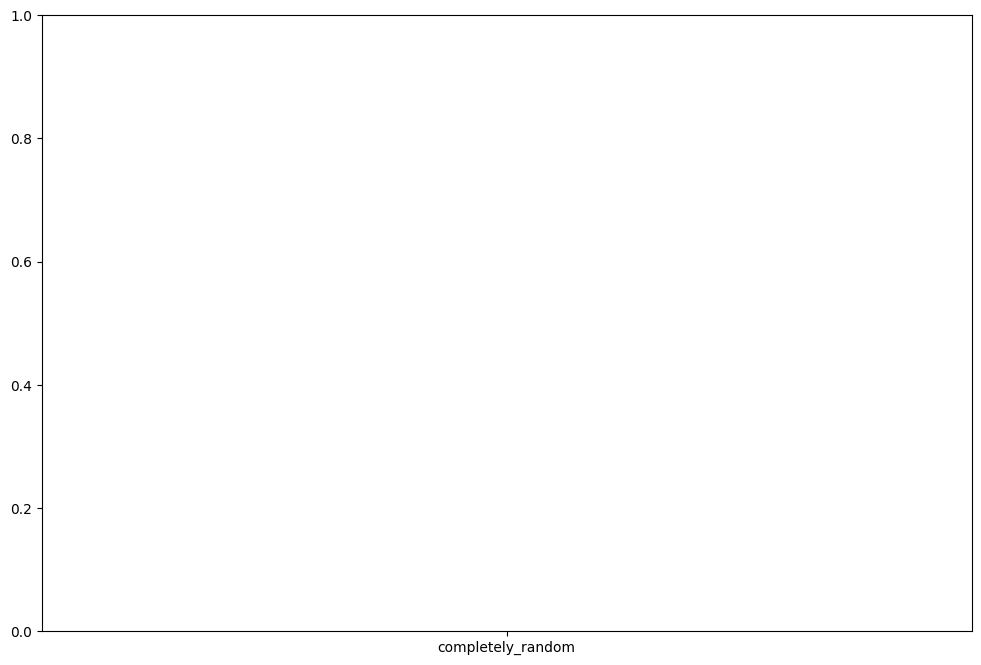

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import itertools
import os
import pandas as pd
import numpy as np
import seaborn as sns

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configuration Parameters
config = {
    "input_dim": 784,          # Number of input features (28x28 images flattened)
    "output_dim": 10,          # Number of output classes (digits 0-9)
    "trainable_units": 128,    # Number of units in each trainable layer
    "fixed_units": 64,         # Number of units in each fixed random layer
    "batch_size": 60000,        # Batch size for training
    "epochs": 25,              # Number of epochs to train
    "learning_rate": 0.001,    # Learning rate for the optimizer
    "data_subset": 1.0,        # Fraction of the data to use for training (0 < data_subset <= 1.0)
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # Device configuration
    "num_workers": 8           # Number of workers for DataLoader
}

print(f"Using device: {config['device']}")

# Ensure the output directory exists
output_dir = "pareto_front_results"
os.makedirs(output_dir, exist_ok=True)

# Model Definitions
class FixedRandomLayer(nn.Module):
    """Layer with fixed random weights, no training, using different initialization strategies."""
    def __init__(self, input_dim, output_dim, device, initialization_strategy):
        super(FixedRandomLayer, self).__init__()
        self.initialization_strategy = initialization_strategy
        self.residual = False
        if initialization_strategy == "residual":
            assert input_dim == output_dim, "Residual connections require input_dim == output_dim"
            self.residual = True
        self.weights = torch.empty(input_dim, output_dim, device=device)
        if initialization_strategy == "completely_random":
            self.weights = torch.randn(input_dim, output_dim, device=device)
        elif initialization_strategy == "he":
            nn.init.kaiming_uniform_(self.weights, nonlinearity='relu')
        elif initialization_strategy == "he_normalize":
            nn.init.kaiming_uniform_(self.weights, nonlinearity='relu')
            self.norm = nn.LayerNorm(output_dim).to(device)
        elif initialization_strategy == "orthogonal":
            nn.init.orthogonal_(self.weights)
        elif initialization_strategy == "residual":
            nn.init.kaiming_uniform_(self.weights, nonlinearity='relu')
        else:
            raise ValueError(f"Unknown initialization strategy: {initialization_strategy}")
    
    def forward(self, x):
        out = x.mm(self.weights)
        if self.initialization_strategy == "he_normalize":
            out = self.norm(out)
        if self.residual:
            out = x + out
        return out

class TestNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, 
                 trainable_layers, trainable_units,
                 fixed_layers, fixed_units, device, initialization_strategy):
        super(TestNetwork, self).__init__()
        
        self.layers = nn.ModuleList()
        
        # Calculate the number of trainable layers before and after fixed layers
        n_trainable_before = trainable_layers // 2
        n_trainable_after = trainable_layers - n_trainable_before
        
        last_dim = input_dim
        
        # Add trainable layers before fixed layers
        for _ in range(n_trainable_before):
            self.layers.append(nn.Linear(last_dim, trainable_units))
            self.layers.append(nn.ReLU())
            last_dim = trainable_units
        
        # Add fixed random layers
        for _ in range(fixed_layers):
            if initialization_strategy == "residual":
                # For residual, fixed_units must equal trainable_units
                unit = trainable_units
            else:
                unit = fixed_units
            self.layers.append(FixedRandomLayer(last_dim, unit, device, initialization_strategy))
            last_dim = unit
        
        # Add trainable layers after fixed layers
        for _ in range(n_trainable_after):
            self.layers.append(nn.Linear(last_dim, trainable_units))
            self.layers.append(nn.ReLU())
            last_dim = trainable_units
        
        # Output layer
        self.output = nn.Linear(last_dim, output_dim)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output(x)

# Model Creation Function
def create_model(config, initialization_strategy):
    """Creates and returns the model based on the configuration and initialization strategy."""
    # Adjust fixed_units for residual connections
    if initialization_strategy == "residual":
        fixed_units = config["trainable_units"]
    else:
        fixed_units = config["fixed_units"]
    
    model = TestNetwork(
        input_dim=config["input_dim"], 
        output_dim=config["output_dim"], 
        trainable_layers=config["trainable_layers"], 
        trainable_units=config["trainable_units"],  # Using single value for all layers
        fixed_layers=config["fixed_layers"], 
        fixed_units=fixed_units,  # Using single value for all layers
        device=config["device"],
        initialization_strategy=initialization_strategy
    ).to(config["device"])
    return model

# Data Loading and Pre-loading Function
def load_and_preload_data(config):
    """Loads the MNIST dataset, moves it to the GPU, and returns in-memory datasets."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load the dataset into CPU memory first
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Use a subset of the training data if data_subset < 1.0
    max_length = len(trainset)
    subset_length = int(max_length * config["data_subset"])
    print(f"Maximum length of the dataset: {max_length}")
    print(f"Using {subset_length} samples for training ({config['data_subset']*100:.1f}% of the dataset)")
    if config["data_subset"] < 1.0:
        trainset = torch.utils.data.Subset(trainset, range(subset_length))

    # Determine actual batch size based on subset_length
    actual_batch_size = min(config["batch_size"], subset_length)

    # Load entire train and test datasets
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=actual_batch_size, shuffle=False, num_workers=config["num_workers"])
    testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False, num_workers=config["num_workers"])

    # Pre-load entire training and testing dataset into GPU memory
    train_data, train_labels = next(iter(trainloader))
    train_data = train_data.view(-1, config["input_dim"]).to(config["device"])
    train_labels = train_labels.to(config["device"])

    test_data, test_labels = next(iter(testloader))
    test_data = test_data.view(-1, config["input_dim"]).to(config["device"])
    test_labels = test_labels.to(config["device"])

    return (train_data, train_labels), (test_data, test_labels)

# Evaluation Function
def evaluate_model(model, test_data, test_labels, config):
    """Evaluates the model on the test data and returns the accuracy."""
    correct = 0
    total = test_labels.size(0)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(test_data)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == test_labels).sum().item()
    model.train()  # Set model back to training mode
    return 100 * correct / total

# Training Function
def train_model(model, train_data, train_labels, test_data, test_labels, config):
    """Trains the model using the given dataset and configuration."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    # Calculate number of batches per epoch
    total_steps_per_epoch = (train_data.size(0) + config["batch_size"] -1) // config["batch_size"]
    total_steps = total_steps_per_epoch * config["epochs"]

    for epoch in range(config["epochs"]):
        running_loss = 0.0

        for i in range(total_steps_per_epoch):
            # Get a batch of data
            start = i * config["batch_size"]
            end = start + config["batch_size"]
            inputs = train_data[start:end]
            labels = train_labels[start:end]

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate on the test set after each epoch
        test_accuracy = evaluate_model(model, test_data, test_labels, config)

        # Calculate the number of trainable parameters
        num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        # Calculate the number of random parameters (weights in FixedRandomLayer)
        num_random_params = sum(layer.weights.numel() for layer in model.layers if isinstance(layer, FixedRandomLayer))

        ratio = num_trainable_params / num_random_params if num_random_params !=0 else float('inf')

        # Calculate total random parameter size
        total_random_params = num_random_params

        # Print the result
        #print(f"Epoch {epoch +1}/{config['epochs']} - Test Accuracy: {test_accuracy:.2f}% - Ratio: {ratio:.2f} - Total Random Params: {total_random_params}")

        # Return the final test accuracy for this epoch
    return test_accuracy

# Define Initialization Strategies
initialization_strategies = [
    "completely_random",
    "he",
    "he_normalize",
    "orthogonal",
    "residual"
]

# Generate 100 combinations of (fixed_layers, trainable_layers)
# Using fixed_layers and trainable_layers from 5 to 50 in steps of 5 (10 values each)
fixed_layers_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
trainable_layers_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
layer_combinations = list(itertools.product(fixed_layers_list, trainable_layers_list))  # 10 x 10 = 100 combinations

# Initialize results dictionary
results = {strategy: [] for strategy in initialization_strategies}

# Load and preload data once
# However, since different experiments have different trainable_layers and fixed_layers,
# and data_subset is fixed, it's possible to reuse the preloaded data.

# Preload all data once
(train_data_full, train_labels_full), (test_data_full, test_labels_full) = load_and_preload_data(config)

# Iterate through each initialization strategy
for strategy in initialization_strategies:
    print(f"\nStarting experiments with initialization strategy: {strategy}")
    for idx, (fixed_layers, trainable_layers) in enumerate(layer_combinations, 1):
        # Update configuration for current experiment
        config["fixed_layers"] = fixed_layers
        config["trainable_layers"] = trainable_layers

        # Adjust fixed_units for residual connections
        if strategy == "residual":
            config["fixed_units"] = config["trainable_units"]
        else:
            config["fixed_units"] = 64

        # Create model
        try:
            model = create_model(config, strategy)
        except AssertionError as e:
            print(f"Skipping combination (Fixed: {fixed_layers}, Trainable: {trainable_layers}) due to error: {e}")
            continue  # Skip invalid configurations

        # Train the model
        test_accuracy = train_model(model, train_data_full, train_labels_full, test_data_full, test_labels_full, config)

        num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        # Calculate the number of random parameters (weights in FixedRandomLayer)
        num_random_params = sum(layer.weights.numel() for layer in model.layers if isinstance(layer, FixedRandomLayer))

        ratio = num_trainable_params / num_random_params if num_random_params !=0 else float('inf')

        # Calculate total random parameter size
        total_random_params = num_random_params

        # Record the result
        results[strategy].append({
            "fixed_layers": fixed_layers,
            "trainable_layers": trainable_layers,
            "ratio": ratio,
            "total_random_params": total_random_params,
            "test_accuracy": test_accuracy
        })

        # Print the result
        print(f"Experiment {idx}/100 for {strategy}: Ratio={ratio:.2f}, Total Random Params={total_random_params}, Test Accuracy={test_accuracy:.2f}%")

# Save results to CSV files
for strategy in initialization_strategies:
    df = pd.DataFrame(results[strategy])
    df.to_csv(os.path.join(output_dir, f"{strategy}_results.csv"), index=False)

# Visualization

# 1. Plot Accuracy vs Ratio for each strategy
for strategy in initialization_strategies:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pd.DataFrame(results[strategy]), x='ratio', y='test_accuracy', alpha=0.6)
    plt.title(f"Final Test Accuracy vs Trainable/Random Ratio ({strategy})")
    plt.xlabel("Trainable/Random Parameters Ratio")
    plt.ylabel("Final Test Accuracy (%)")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f"{strategy}_accuracy_vs_ratio.png"))
    plt.close()

# 2. Plot Accuracy vs Total Random Parameters for each strategy
for strategy in initialization_strategies:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pd.DataFrame(results[strategy]), x='total_random_params', y='test_accuracy', alpha=0.6)
    plt.title(f"Final Test Accuracy vs Total Random Parameters ({strategy})")
    plt.xlabel("Total Random Parameters")
    plt.ylabel("Final Test Accuracy (%)")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f"{strategy}_accuracy_vs_total_random_params.png"))
    plt.close()

# Combined Plot 1: All strategies - Accuracy vs Ratio
plt.figure(figsize=(12, 8))
for strategy in initialization_strategies:
    df = pd.DataFrame(results[strategy])
    sns.scatterplot(data=df, x='ratio', y='test_accuracy', label=strategy, alpha=0.6)
plt.title("Final Test Accuracy vs Trainable/Random Parameters Ratio (All Strategies)")
plt.xlabel("Trainable/Random Parameters Ratio")
plt.ylabel("Final Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, f"Combined_accuracy_vs_ratio.png"))
plt.close()

# Combined Plot 2: All strategies - Accuracy vs Total Random Parameters
plt.figure(figsize=(12, 8))
for strategy in initialization_strategies:
    df = pd.DataFrame(results[strategy])
    sns.scatterplot(data=df, x='total_random_params', y='test_accuracy', label=strategy, alpha=0.6)
plt.title("Final Test Accuracy vs Total Random Parameters (All Strategies)")
plt.xlabel("Total Random Parameters")
plt.ylabel("Final Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, f"Combined_accuracy_vs_total_random_params.png"))
plt.close()

# Statistical Analysis
summary_stats = {}
for strategy in initialization_strategies:
    df = pd.DataFrame(results[strategy])
    summary_stats[strategy] = {
        "mean_accuracy": df['test_accuracy'].mean(),
        "std_accuracy": df['test_accuracy'].std(),
        "mean_ratio": df['ratio'].mean(),
        "std_ratio": df['ratio'].std(),
        "mean_total_random_params": df['total_random_params'].mean(),
        "std_total_random_params": df['total_random_params'].std()
    }

# Convert summary_stats to DataFrame for better readability
summary_df = pd.DataFrame(summary_stats).T
print("\nStatistical Analysis Summary:")
print(summary_df)

# Save summary statistics to CSV
summary_df.to_csv(os.path.join(output_dir, "summary_statistics.csv"))

# Combined Statistical Plots
# 1. Mean Accuracy with Error Bars for Each Strategy
plt.figure(figsize=(12, 8))
mean_accuracies = [summary_stats[strategy]["mean_accuracy"] for strategy in initialization_strategies]
std_accuracies = [summary_stats[strategy]["std_accuracy"] for strategy in initialization_strategies]
sns.barplot(x=initialization_strategies, y=mean_accuracies, yerr=std_accuracies, capsize=0.2)
plt.title("Mean Test Accuracy with Standard Deviation (All Strategies)")
plt.xlabel("Initialization Strategy")
plt.ylabel("Mean Test Accuracy (%)")
plt.grid(True, axis='y')
plt.savefig(os.path.join(output_dir, f"Combined_mean_accuracy.png"))
plt.close()

# 2. Mean Ratio with Error Bars for Each Strategy
plt.figure(figsize=(12, 8))
mean_ratios = [summary_stats[strategy]["mean_ratio"] for strategy in initialization_strategies]
std_ratios = [summary_stats[strategy]["std_ratio"] for strategy in initialization_strategies]
sns.barplot(x=initialization_strategies, y=mean_ratios, yerr=std_ratios, capsize=0.2)
plt.title("Mean Trainable/Random Parameters Ratio with Standard Deviation (All Strategies)")
plt.xlabel("Initialization Strategy")
plt.ylabel("Mean Trainable/Random Parameters Ratio")
plt.grid(True, axis='y')
plt.savefig(os.path.join(output_dir, f"Combined_mean_ratio.png"))
plt.close()

print("\nAll experiments completed and results saved.")


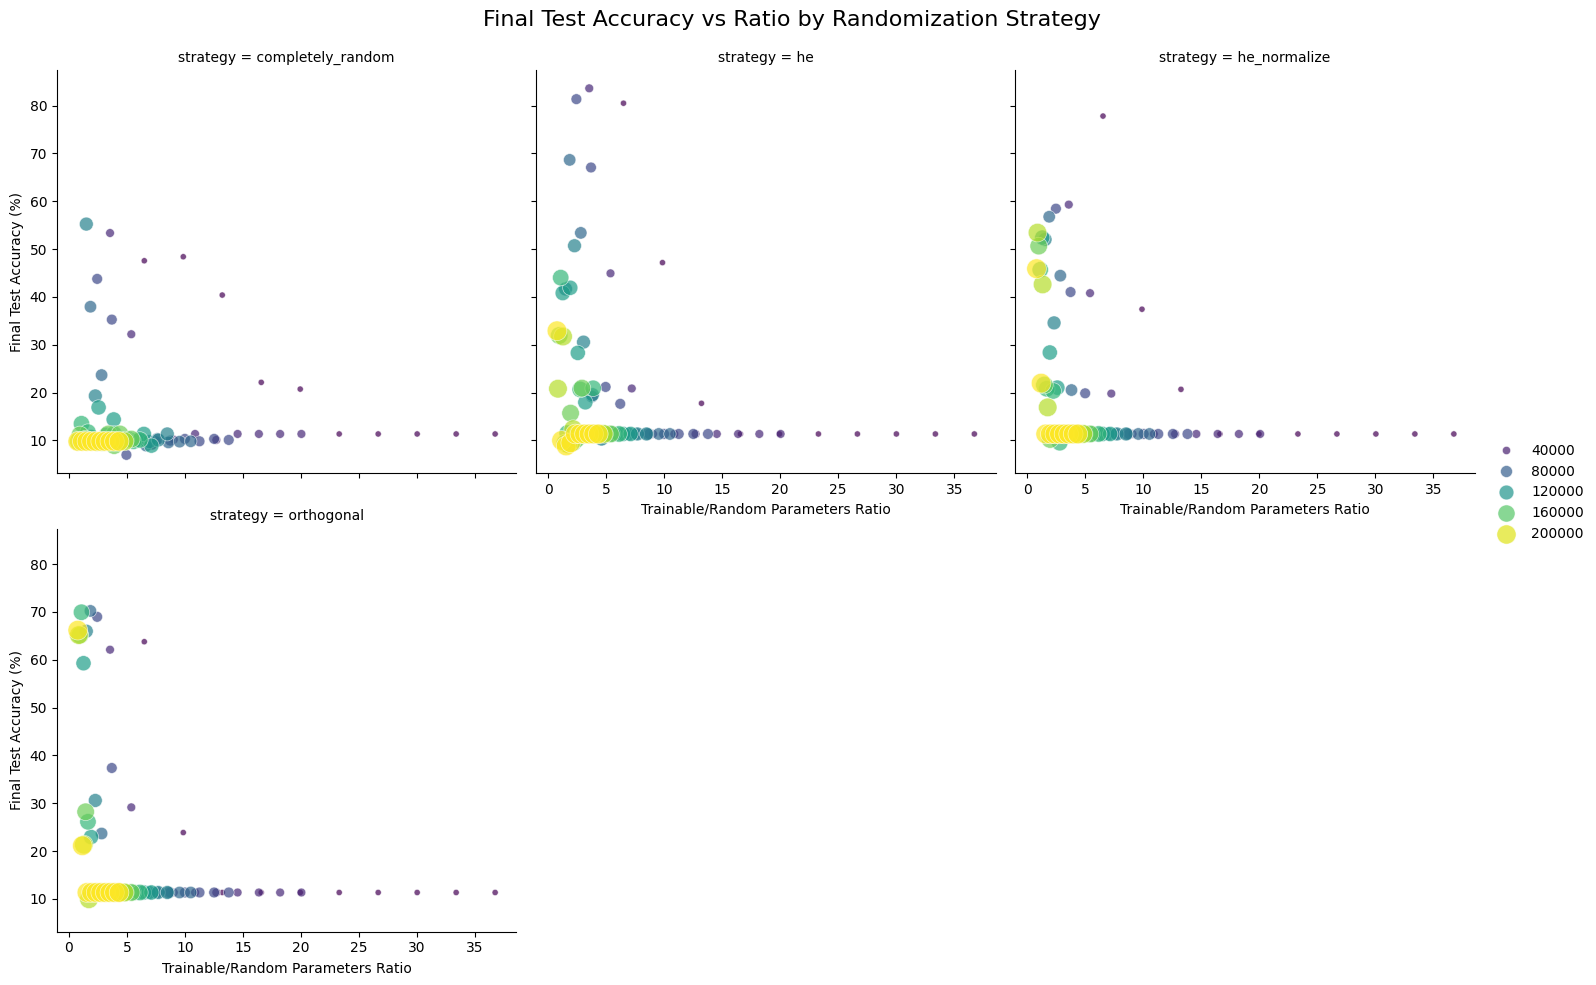

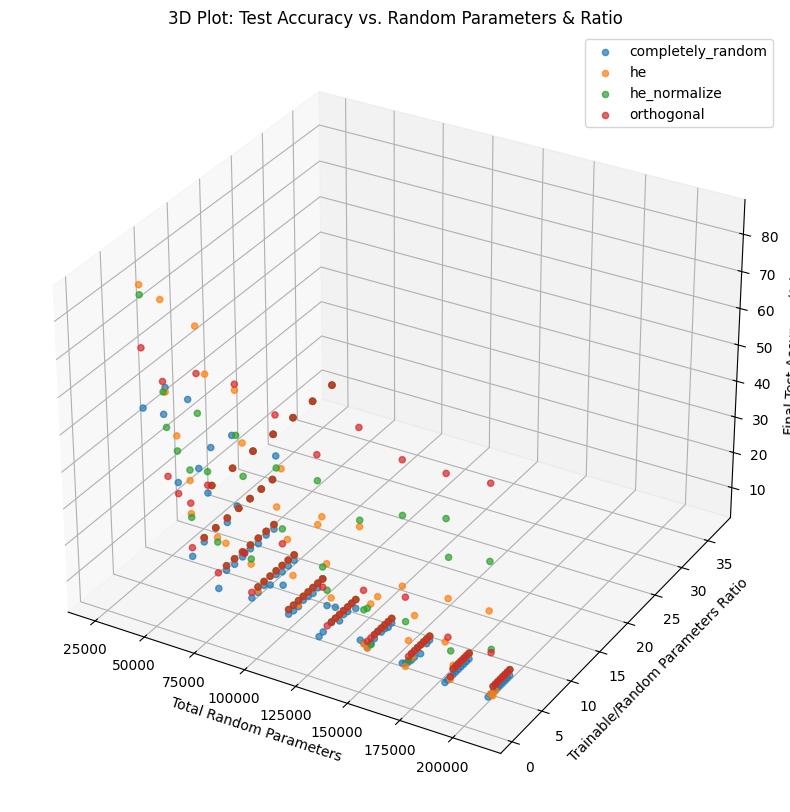

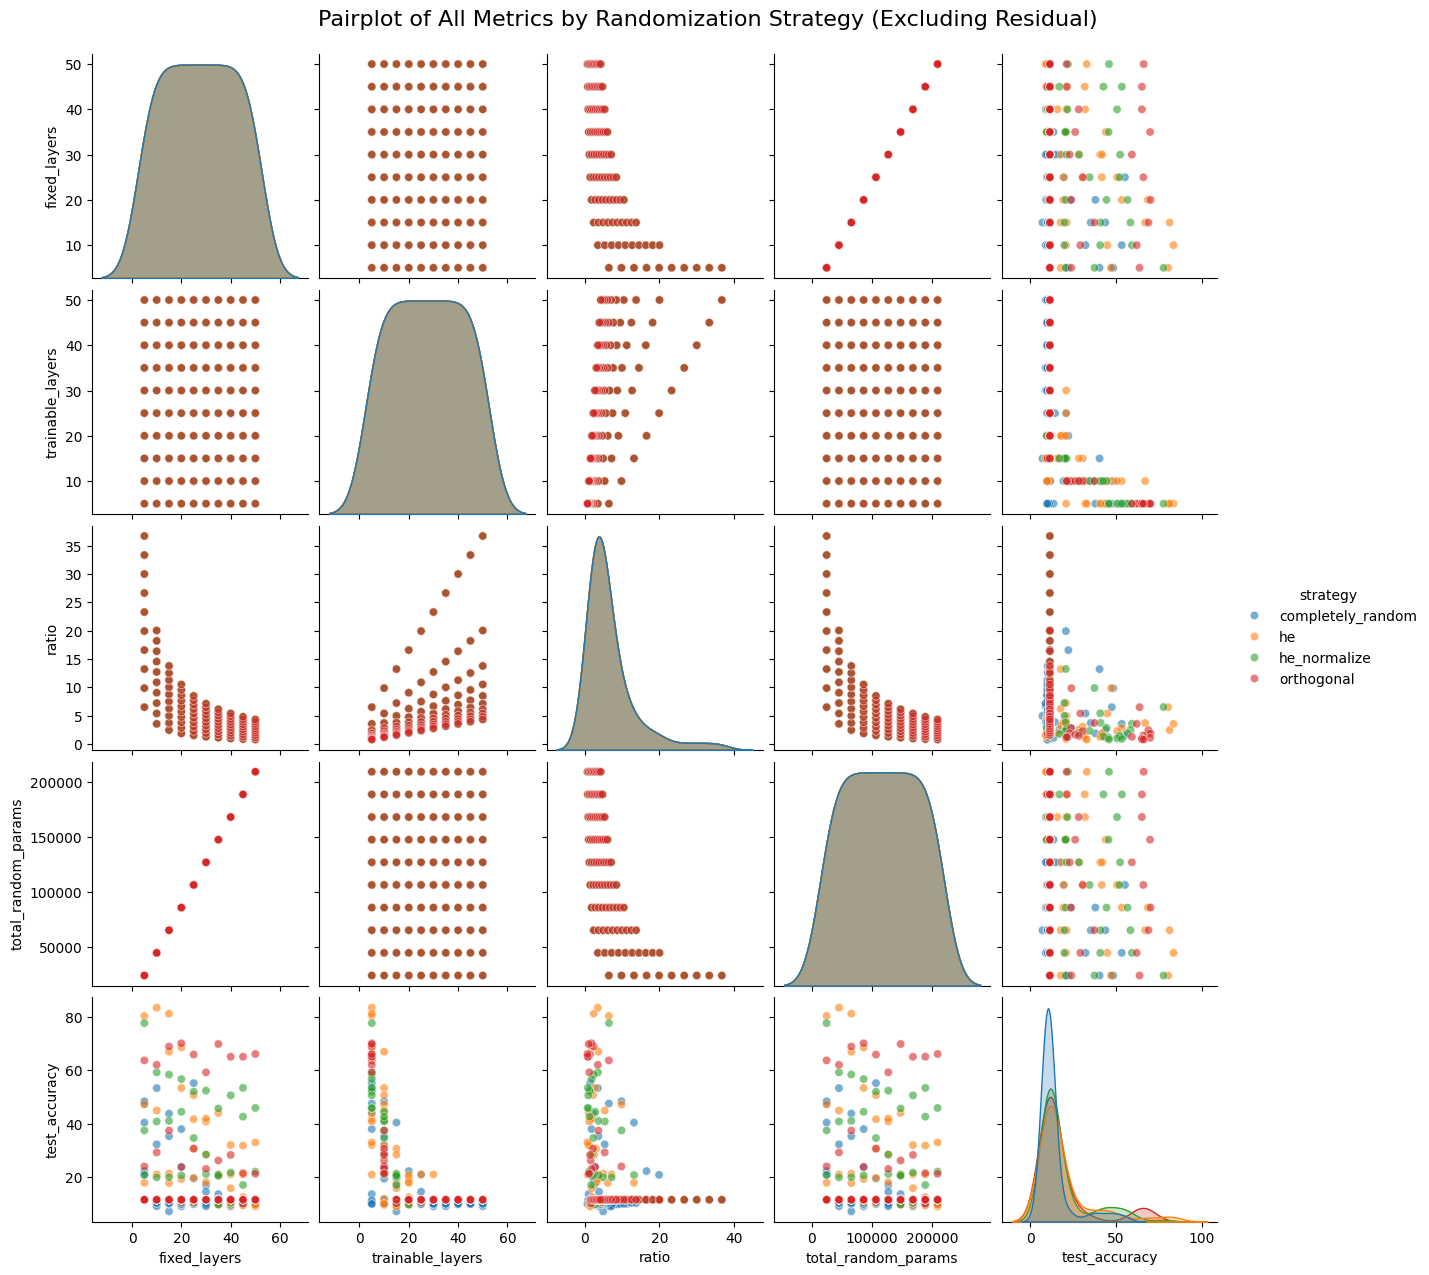

In [14]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Convert the results dictionary to a combined DataFrame
all_results = []
for strategy in initialization_strategies:
    if strategy == "residual":
        continue  # Skip the residual strategy
    df = pd.DataFrame(results[strategy])
    df["strategy"] = strategy  # Add a column for strategy
    all_results.append(df)

all_results_df = pd.concat(all_results, ignore_index=True)

# Facet Grid Scatter Plot
g = sns.FacetGrid(all_results_df, col="strategy", col_wrap=3, height=5)
g.map_dataframe(sns.scatterplot, x="ratio", y="test_accuracy", size="total_random_params", sizes=(20, 200), hue="total_random_params", palette="viridis", alpha=0.7)
g.add_legend()
g.set_axis_labels("Trainable/Random Parameters Ratio", "Final Test Accuracy (%)")
g.fig.suptitle("Final Test Accuracy vs Ratio by Randomization Strategy", fontsize=16)
plt.subplots_adjust(top=0.92)  # Adjust the title position
g.savefig(os.path.join(output_dir, f"FacetGrid_accuracy_vs_ratio.png"))
plt.show()

# 3D Scatter Plot for each strategy (Optional)
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each strategy with a different color
for strategy in initialization_strategies:
    if strategy == "residual":
        continue  # Skip the residual strategy
    df = all_results_df[all_results_df["strategy"] == strategy]
    ax.scatter(df["total_random_params"], df["ratio"], df["test_accuracy"], label=strategy, alpha=0.7)

ax.set_xlabel("Total Random Parameters")
ax.set_ylabel("Trainable/Random Parameters Ratio")
ax.set_zlabel("Final Test Accuracy (%)")
ax.set_title("3D Plot: Test Accuracy vs. Random Parameters & Ratio")
ax.legend()
plt.savefig(os.path.join(output_dir, f"3D_accuracy_vs_random_ratio.png"))
plt.show()

# Pairplot Visualization (excluding residual strategy)
sns.pairplot(all_results_df, hue="strategy", diag_kind="kde", plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot of All Metrics by Randomization Strategy (Excluding Residual)", y=1.02, fontsize=16)
plt.savefig(os.path.join(output_dir, f"Pairplot_all_metrics.png"))
plt.show()


ValueError: 'yerr' (shape: (5,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

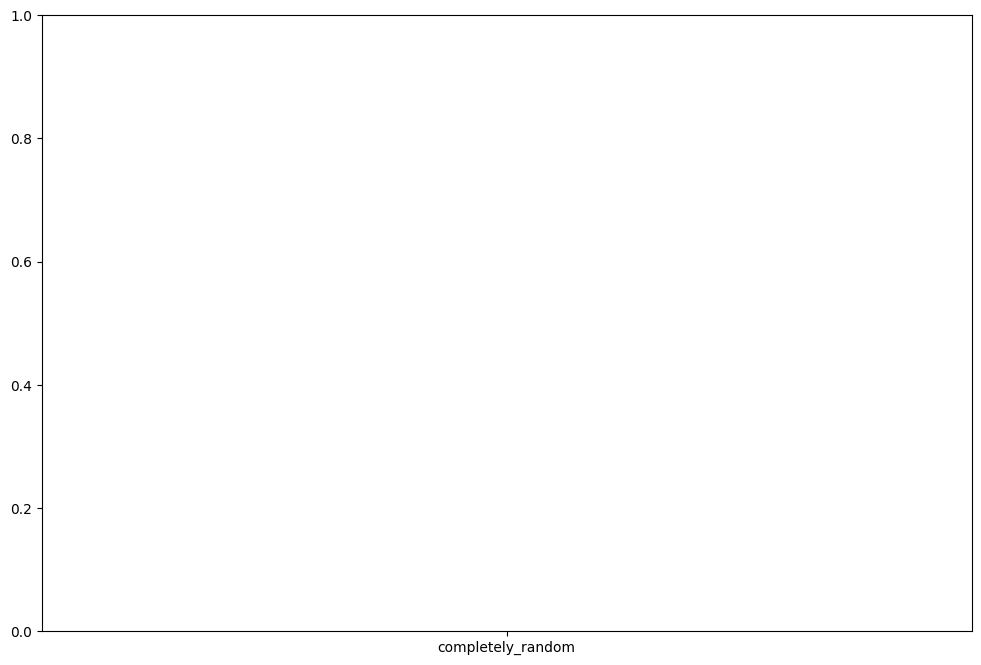

In [15]:
# Combined Statistical Plots

# 1. Mean Accuracy with Error Bars for Each Strategy
plt.figure(figsize=(12, 8))
mean_accuracies = [summary_stats[strategy]["mean_accuracy"] for strategy in initialization_strategies]
std_accuracies = [summary_stats[strategy]["std_accuracy"] for strategy in initialization_strategies]

# Convert std_accuracies to a format compatible with yerr
# yerr should be a list or array of error values for each bar in the plot
yerr = np.array(std_accuracies)

# Check if the lengths of mean_accuracies and yerr are the same
if len(mean_accuracies) == len(yerr):
    sns.barplot(x=initialization_strategies, y=mean_accuracies, yerr=yerr, capsize=0.2)
    plt.title("Mean Test Accuracy with Standard Deviation (All Strategies)")
    plt.xlabel("Initialization Strategy")
    plt.ylabel("Mean Test Accuracy (%)")
    plt.grid(True, axis='y')
    plt.savefig(os.path.join(output_dir, f"Combined_mean_accuracy.png"))
    plt.show()
else:
    print(f"Shape mismatch: mean_accuracies has {len(mean_accuracies)} elements, but yerr has {len(yerr)} elements.")

# 2. Mean Ratio with Error Bars for Each Strategy
plt.figure(figsize=(12, 8))
mean_ratios = [summary_stats[strategy]["mean_ratio"] for strategy in initialization_strategies]
std_ratios = [summary_stats[strategy]["std_ratio"] for strategy in initialization_strategies]

# Convert std_ratios to a format compatible with yerr
yerr = np.array(std_ratios)

# Check if the lengths of mean_ratios and yerr are the same
if len(mean_ratios) == len(yerr):
    sns.barplot(x=initialization_strategies, y=mean_ratios, yerr=yerr, capsize=0.2)
    plt.title("Mean Trainable/Random Parameters Ratio with Standard Deviation (All Strategies)")
    plt.xlabel("Initialization Strategy")
    plt.ylabel("Mean Trainable/Random Parameters Ratio")
    plt.grid(True, axis='y')
    plt.savefig(os.path.join(output_dir, f"Combined_mean_ratio.png"))
    plt.show()
else:
    print(f"Shape mismatch: mean_ratios has {len(mean_ratios)} elements, but yerr has {len(yerr)} elements.")
